# DCGAN Ensemble Model 1 (eGANs) training

After training the DCGAN Control Model (CM), now we will start training ensemble models, in this notebook we will train the first type following [Ensembles of Generative Adversarial Networks](https://arxiv.org/pdf/1612.00991.pdf) paper.

__Ensemble Model 1 (EM1): Standard Ensemble of GANs (eGANs)__.

According to the paper, the idea for this ensemble is that:

> Instead of training a single GAN model on the data, one trains a set of GAN models from scratch from a random initialization of the parameters. When generating data one randomly chooses one of the GAN models and then generates the data according to that model.

In other words, this process have two parts:

* In training phase: we train multiple models from scratch and save each of those.
* In generation phase: we choose one of the models randomly each time we need to generate a sample image.

Lets import dependencies and define some basic helper functions. Also, most of the helpers defined for CM in the previous notebook will be imported here and just use it as is from em1 folder.

In [1]:
import os
import time
import glob
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import numpy as np
from PIL import Image, ImageOps
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid

# EM1/eGANs helpers
from commons.utils import is_train_on_gpu, view_samples
from commons import data_helpers, gan_models, model_helpers
from em1 import train_helpers

In [2]:
dataset_path = 'data/alzheimers_mri_dataset/train'
models_folder = 'em1/models'
# using an odd batch size, if we use 64 the last batch will have only 1 img and will error out,
# instead if we use 63, the last batch will have 41 images which is ok
batch_size = 63
img_size = 128

demented_dataset, demented_train_loader = data_helpers.get_dataset_dataloader(batch_size, img_size, dataset_path)
print(f'dataset size: {len(demented_dataset)}')

dataset size: 2561


In [3]:
# clean models folder
!rm -rf em1/models
!mkdir -p em1/models

In [4]:
# Hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 200

# default hyperparams values according to DCGAN paper
# learning_rate = 0.0002
# beta1 = 0.5
# beta2 = 0.999
# but adding a small variation in learning rate,
#   changing it made the generator and discriminator losses stabilised a bit more quickly
learning_rate = 0.0001
beta1 = 0.5
beta2 = 0.999

n_epochs = 35
print_every = 100

In [5]:
# EM1 / eGANs hyperparam
# set how many models we are going to train from scratch
number_of_models_to_train = 8

In [6]:
losses_list = []
start_time = time.time()
for model_num in range(1, number_of_models_to_train+1):
    print(f' >>> training model {model_num} started')
    # create discriminator and generator instances
    D, G = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)

    # Create optimizers for the discriminator D and generator G
    d_optimizer = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])

    losses = train_helpers.train(demented_train_loader, D, G, d_optimizer, g_optimizer, z_size, n_epochs=n_epochs, print_every=print_every)
    losses_list.append(losses)
    
    # save trained generator
    model_path = f'{models_folder}/egan{model_num}'
    print(f' *** saving model {model_num}: {model_path}')
    torch.save(G.state_dict(), model_path)
    print(f' >>> training model {model_num} finished')


elapsed_time = time.time() - start_time
elapsed_time_hrs = elapsed_time / 60
print(' *** eGANs models trained successfully %ssec %smin' % (elapsed_time, elapsed_time_hrs))

 >>> training model 1 started
 >>> training started
Epoch [    1/   35] | d_loss: 4.0422 | g_loss: 3.0507
Epoch [    2/   35] | d_loss: 0.0487 | g_loss: 12.8672
Epoch [    3/   35] | d_loss: 0.9976 | g_loss: 16.3252
Epoch [    4/   35] | d_loss: 3.5291 | g_loss: 33.1648
Epoch [    5/   35] | d_loss: 0.0594 | g_loss: 11.6452
Epoch [    6/   35] | d_loss: 1.3717 | g_loss: 7.2188
Epoch [    7/   35] | d_loss: 0.0104 | g_loss: 6.1782
Epoch [    8/   35] | d_loss: 4.9207 | g_loss: 33.3877
Epoch [    9/   35] | d_loss: 0.2447 | g_loss: 9.5429
Epoch [   10/   35] | d_loss: 1.4143 | g_loss: 14.6379
Epoch [   11/   35] | d_loss: 0.1756 | g_loss: 5.8784
Epoch [   12/   35] | d_loss: 0.8986 | g_loss: 13.3395
Epoch [   13/   35] | d_loss: 0.3679 | g_loss: 6.0890
Epoch [   14/   35] | d_loss: 0.8524 | g_loss: 14.5120
Epoch [   15/   35] | d_loss: 0.3244 | g_loss: 7.3645
Epoch [   16/   35] | d_loss: 4.3873 | g_loss: 22.8749
Epoch [   17/   35] | d_loss: 4.0086 | g_loss: 0.7881
Epoch [   18/   35] |

 >>> training finished 752.6626975536346sec 12.544378292560577min
 *** saving model 4: em1/models/egan4
 >>> training model 4 finished
 >>> training model 5 started
 >>> training started
Epoch [    1/   35] | d_loss: 5.4458 | g_loss: 3.5676
Epoch [    2/   35] | d_loss: 0.0000 | g_loss: 29.0641
Epoch [    3/   35] | d_loss: 0.9535 | g_loss: 23.1656
Epoch [    4/   35] | d_loss: 0.9649 | g_loss: 17.3355
Epoch [    5/   35] | d_loss: 0.1199 | g_loss: 4.2274
Epoch [    6/   35] | d_loss: 5.0454 | g_loss: 45.3873
Epoch [    7/   35] | d_loss: 0.0333 | g_loss: 13.3376
Epoch [    8/   35] | d_loss: 0.6761 | g_loss: 11.6920
Epoch [    9/   35] | d_loss: 0.1999 | g_loss: 12.7913
Epoch [   10/   35] | d_loss: 0.0859 | g_loss: 9.4793
Epoch [   11/   35] | d_loss: 0.1470 | g_loss: 10.0382
Epoch [   12/   35] | d_loss: 0.2215 | g_loss: 9.6482
Epoch [   13/   35] | d_loss: 0.9850 | g_loss: 4.1360
Epoch [   14/   35] | d_loss: 0.0689 | g_loss: 6.7739
Epoch [   15/   35] | d_loss: 4.6936 | g_loss: 6.

Epoch [   33/   35] | d_loss: 0.5205 | g_loss: 3.5103
Epoch [   34/   35] | d_loss: 0.1248 | g_loss: 6.2507
Epoch [   35/   35] | d_loss: 4.3850 | g_loss: 15.3849
 >>> training finished 752.6908354759216sec 12.544847257932027min
 *** saving model 8: em1/models/egan8
 >>> training model 8 finished
 *** eGANs models trained successfully 6034.885580062866sec 100.5814263343811min


Apart from specifying the loop where we are going to train the set of models, we can also see that we are saving the state of each model (the weights) in a special folder: `em1/models/egan{model_num}`.

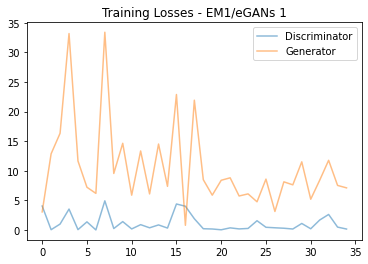

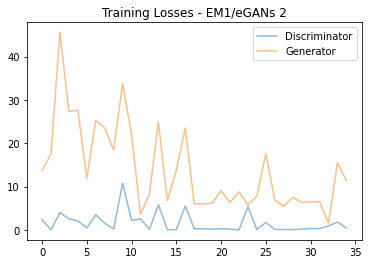

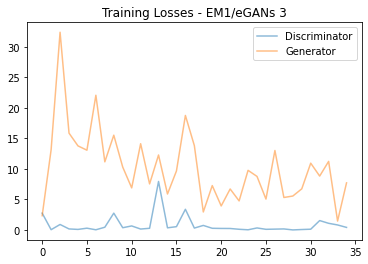

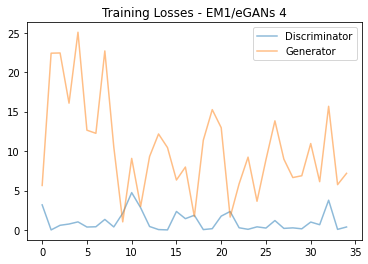

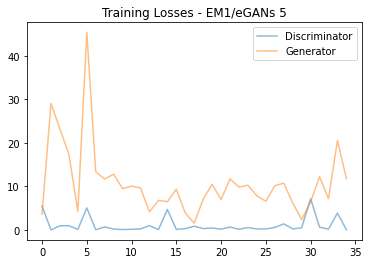

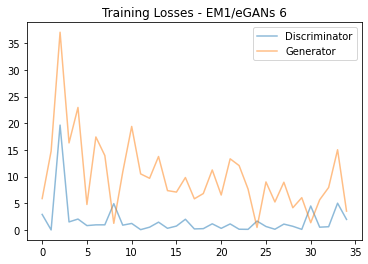

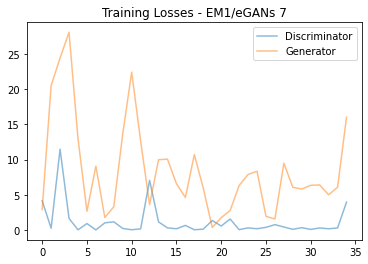

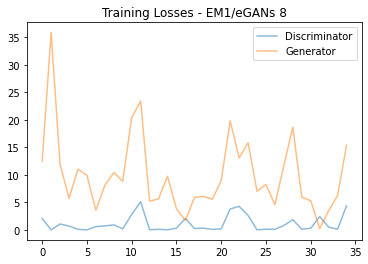

In [7]:
for model_num, losses in enumerate(losses_list):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title(f"Training Losses - EM1/eGANs {model_num+1}")
    plt.legend()

In the last cell, where we are listing the discriminator and generator losses, we can see that for each model values and behavior in general are different. Specially, the generator is finishing in a different value in all models, just confirming that each of the models are capturing many axis of variations. We are hoping that each generator might generalize the dataset in a slightly different way.

Lets instantiate those models and see some of the images that we can generate with them:

 *** instantiating model: em1/models/egan1
 *** instantiating model: em1/models/egan2
 *** instantiating model: em1/models/egan3
 *** instantiating model: em1/models/egan4
 *** instantiating model: em1/models/egan5
 *** instantiating model: em1/models/egan6
 *** instantiating model: em1/models/egan7
 *** instantiating model: em1/models/egan8


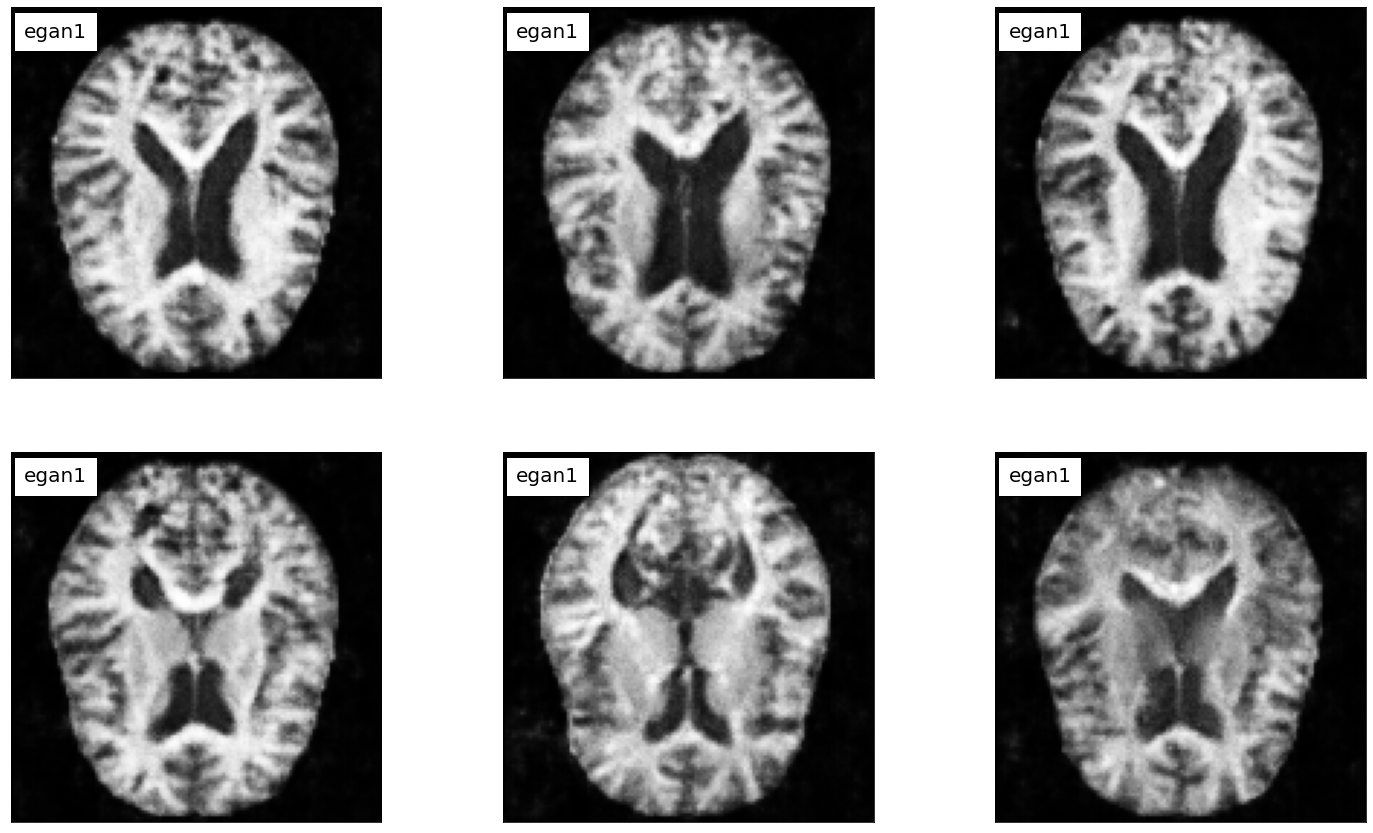

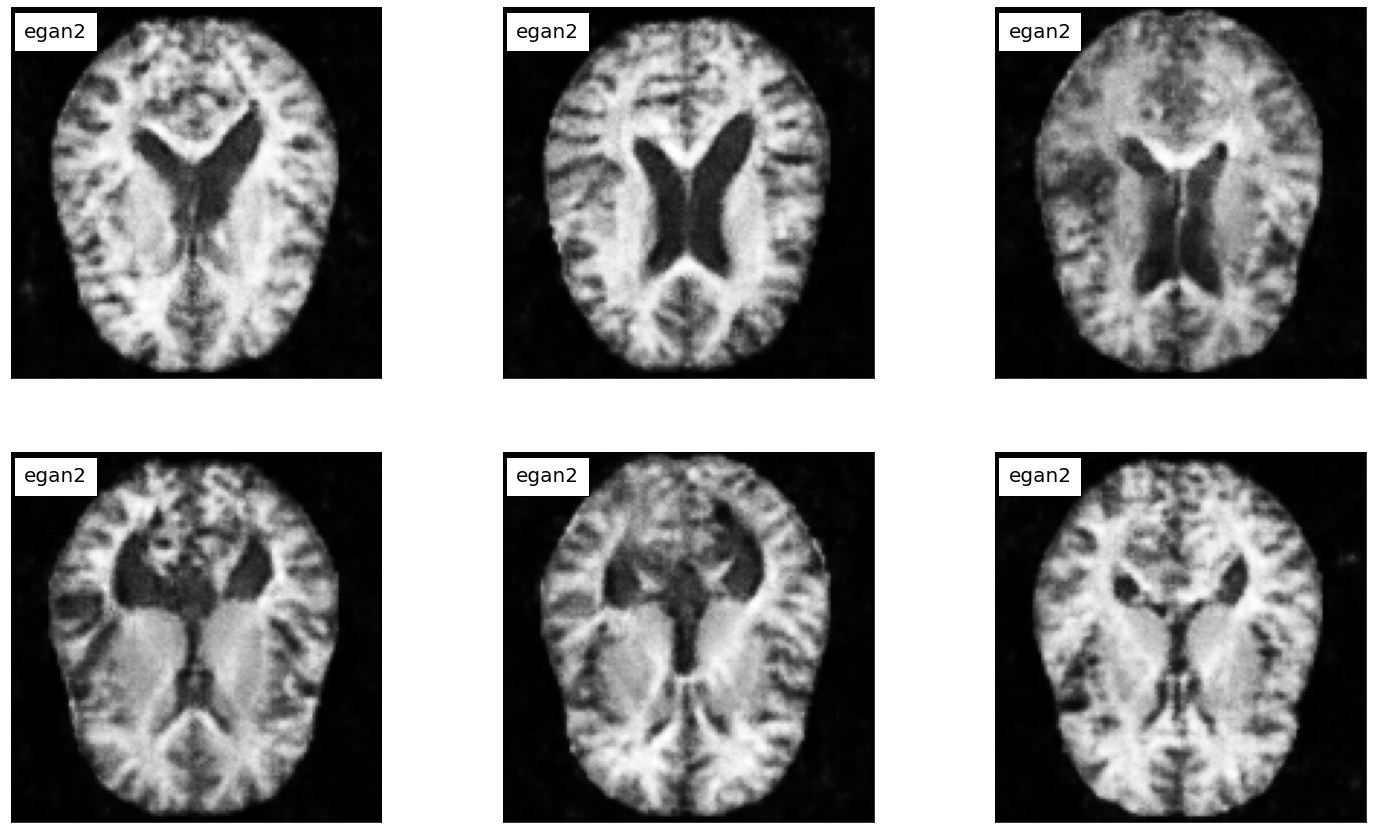

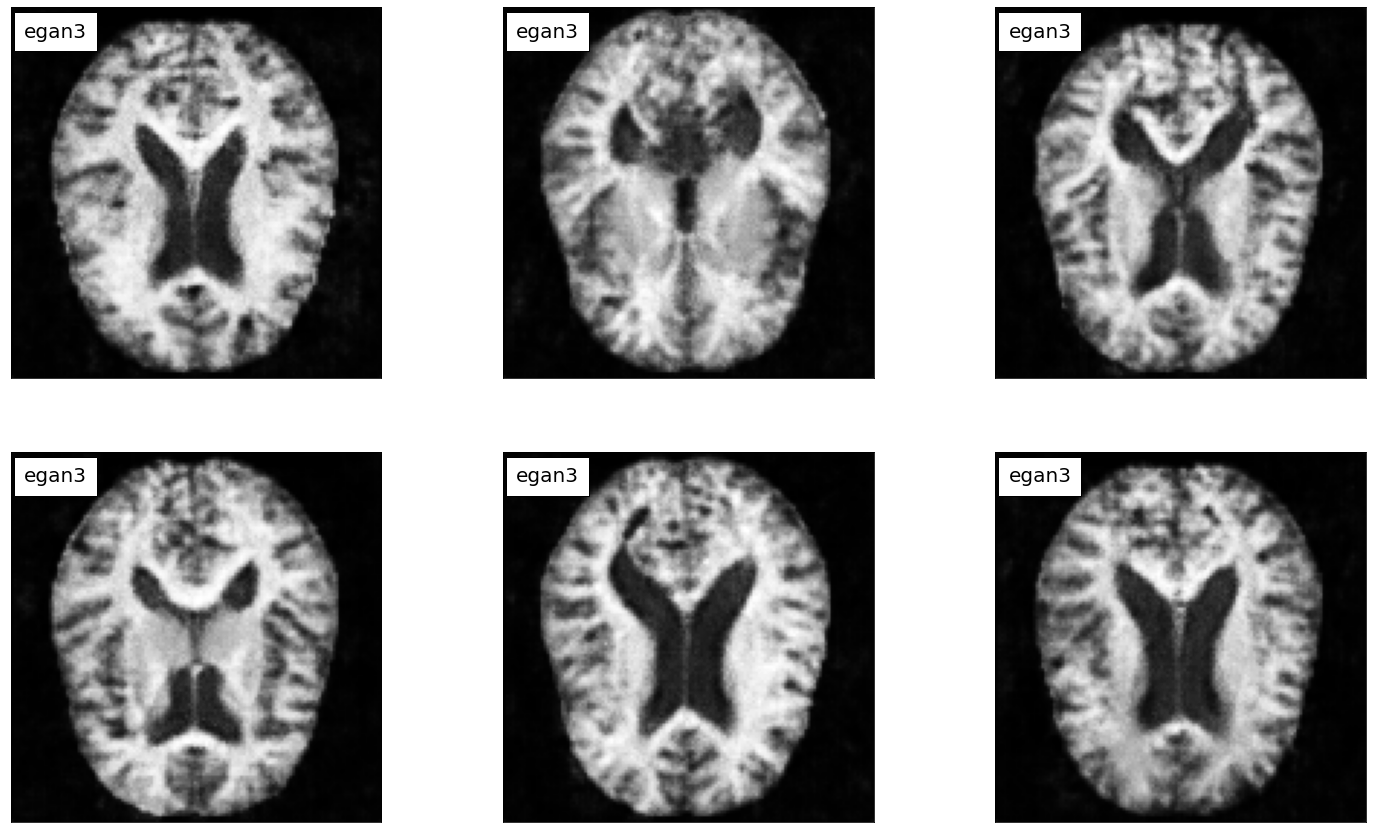

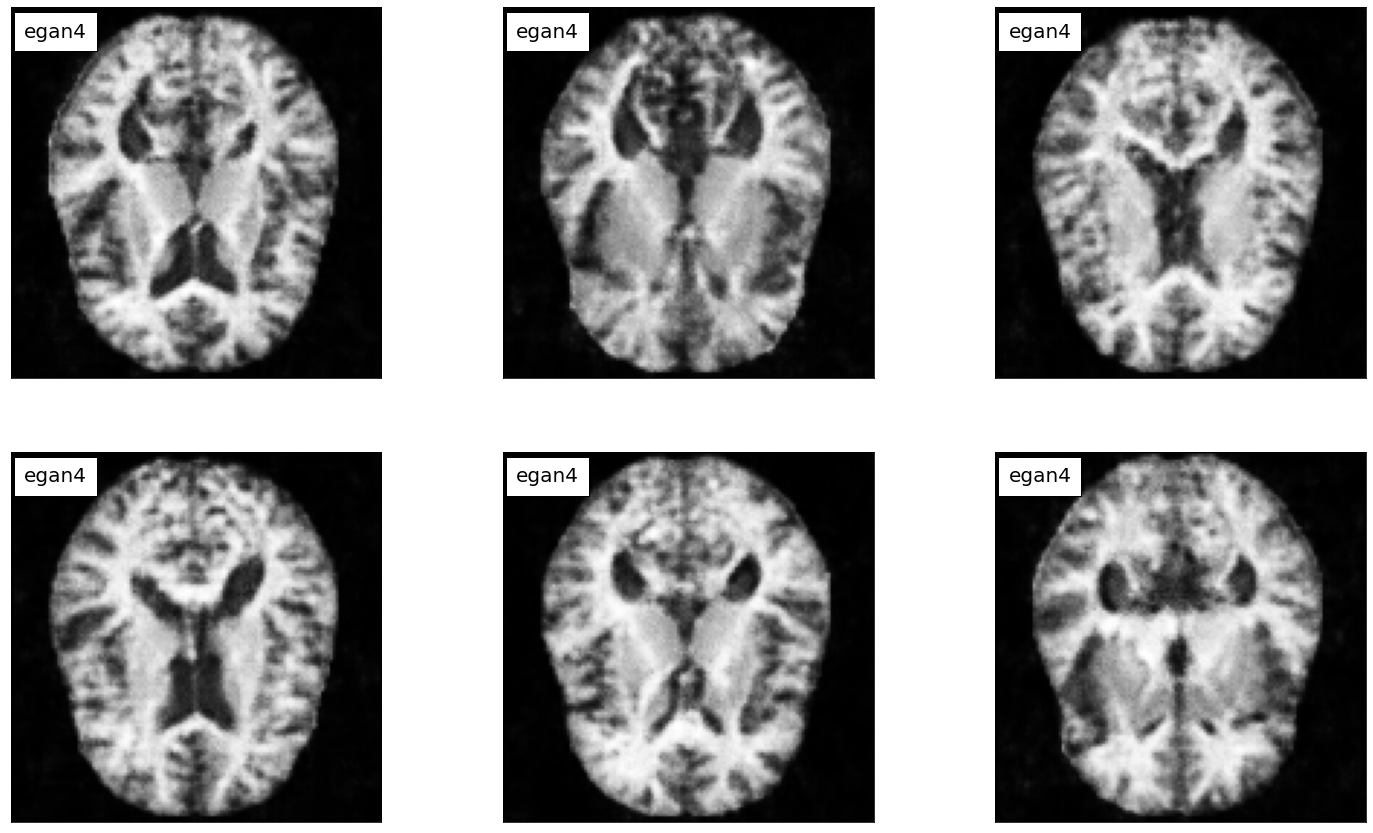

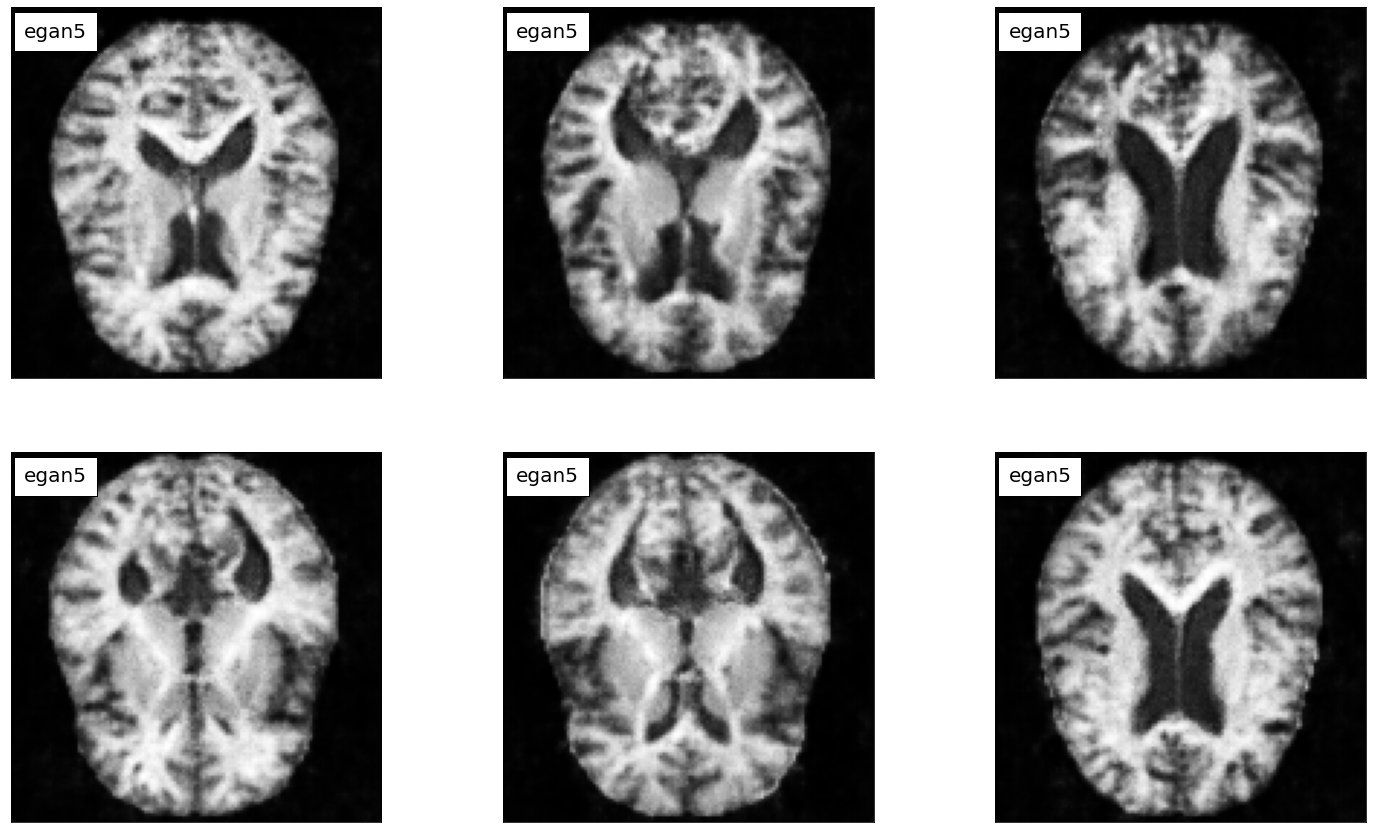

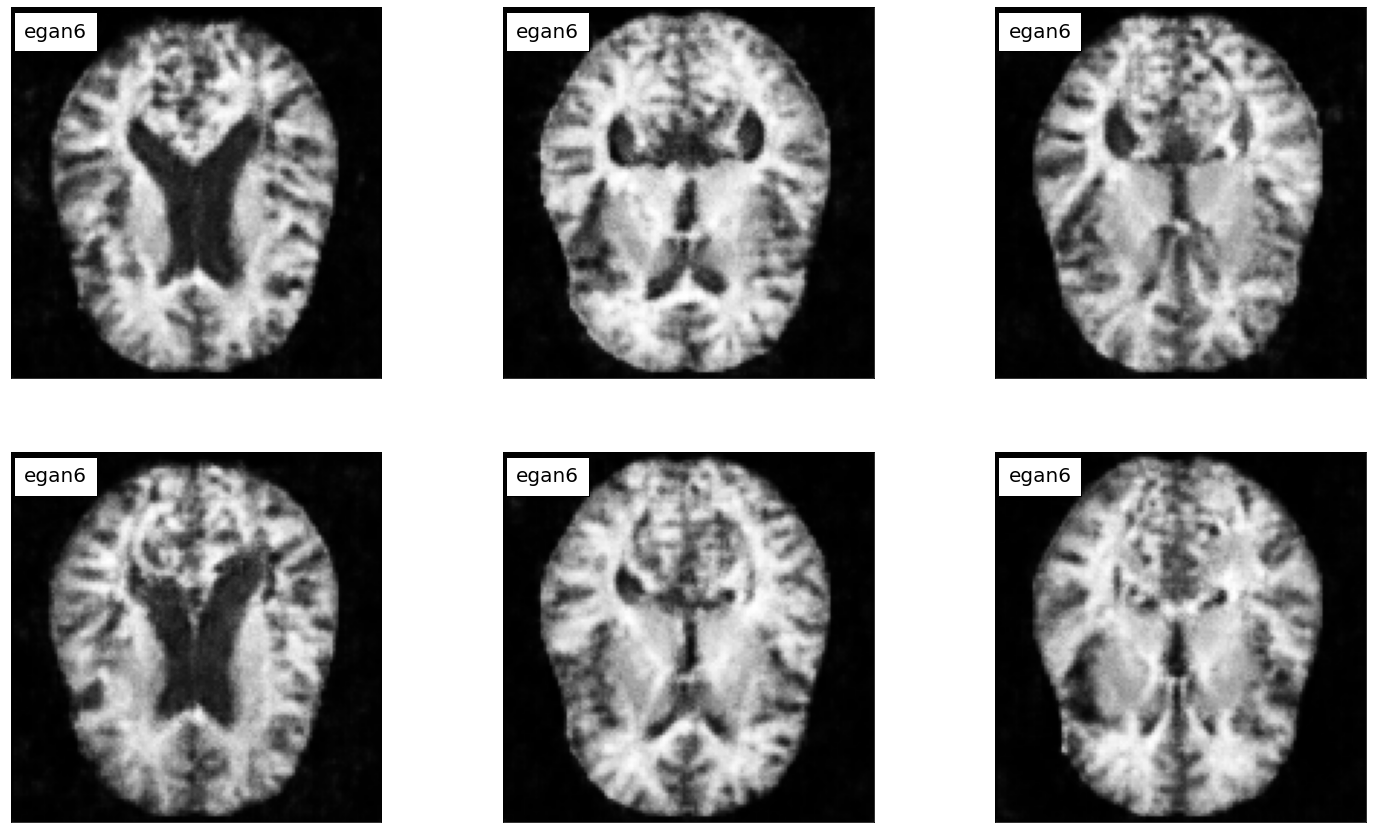

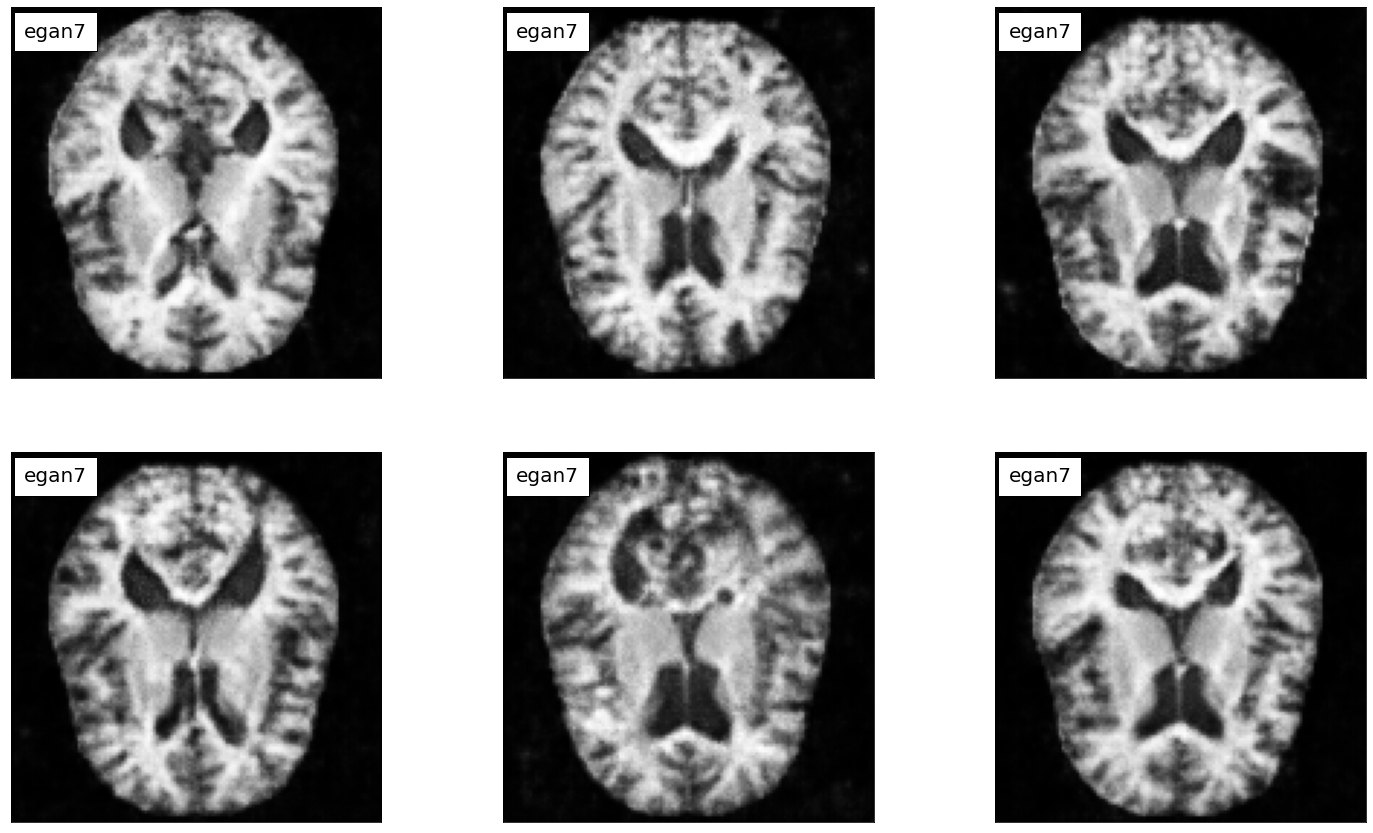

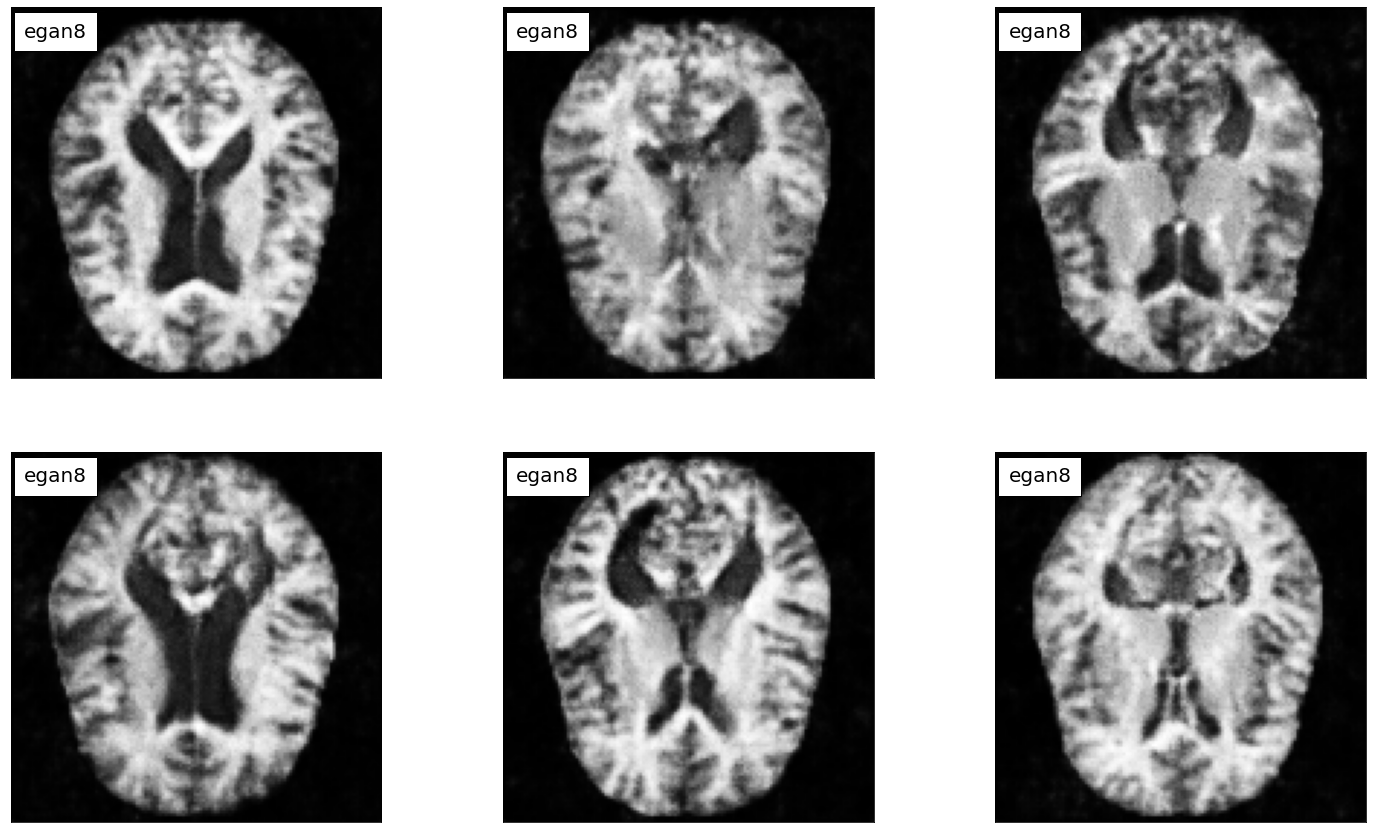

In [8]:
from commons.utils import is_train_on_gpu, view_samples
for model_num in range(1, number_of_models_to_train+1):
    model_path = f'{models_folder}/egan{model_num}'
    print(f' *** instantiating model: {model_path}')

    _, generator = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    
    sample_size = 6
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if is_train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)

    view_samples(samples_z, legend_lbl=f"egan{model_num}")

We can see that for any trained and saved model, we can successfully generate brain MRIs using eGANs models.